# Large language models (LLMs): Part II

Author: Archit Vasan , including materials on LLMs by Varuni Sastri, and discussion/editorial work by Taylor Childers, Carlo Graziani, Bethany Lusch, and Venkat Vishwanath (Argonne)

Inspiration from the blog posts "The Illustrated Transformer" and "The Illustrated GPT2" by Jay Alammar, highly recommended reading.

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-01-10' at the top-left of the Jupyter notebook.

## Overview
1. Training and inference using Hugging Face
2. Elements of an LLM
3. Attention mechanisms
4. Positional encoding
5. Output layers
6. Training loops

In [21]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

## LLM training and inference using HuggingFace

<img src="images/hf-logo-with-title.png" alt="Drawing" style="width: 300px;"/>
HuggingFace is a platform and community that provides open-source library tools and resources like pre-trained models and datasets.
Refer to the following links for more information :

https://huggingface.co/docs/hub/index

https://huggingface.co/docs/transformers/en/index

Warning: _Large Language Models are only as good as their training data. They have no ethics, no judgement, or editing ability. We will be using some pretrained models from Hugging Face which used wide samples of internet hosted text. The datasets have not been strictly filtered to restrict all malign content so the generated text may be surprisingly dark or questionable. They do not reflect our core values and are only used for demonstration purposes._

### Inference

We can use the Huggingface pipeline with a pretrained GPT2 model to generate text given a prompt.

In [31]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig
from transformers import pipeline
input_text = "My dog really wanted to"
generator = pipeline("text-generation", model="openai-community/gpt2")
generator(input_text, max_length=20, num_return_sequences=5)

loading configuration file config.json from cache at /home/aeahmed/.cache/huggingface/hub/models--openai-community--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "_name_or_path": "openai-community/gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_

[{'generated_text': 'My dog really wanted to lick it in such a fashion... she just kept holding it. I thought'},
 {'generated_text': "My dog really wanted to have one of those days where we are like, oh, he's a"},
 {'generated_text': 'My dog really wanted to have her back.\n\n\n"What are you talking about?" she cried'},
 {'generated_text': 'My dog really wanted to be up on the roof for that interview," he said. "I was'},
 {'generated_text': 'My dog really wanted to do this at the beach, and I was really proud of her. She'}]

We will cover  evaluation metrics,as well as safe and responsibilities practices when using LLMs in **Session 8**.

### Training

We can also load in our own dataset and train a model with this data as follows:

In [32]:
!pip install accelerate # on polaris

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [33]:
from transformers import TextDataset,DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128) 
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

In [34]:
from transformers import AutoTokenizer,AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_dataset,test_dataset,data_collator = load_dataset('dataset/train_input.txt','dataset/test_input.txt', tokenizer)


loading configuration file config.json from cache at /home/aeahmed/.cache/huggingface/hub/models--openai-community--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "_name_or_path": "openai-community/gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_

In [35]:
data_collator

DataCollatorForLanguageModeling(tokenizer=GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}), mlm=False, mlm_probability=0.15, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt')

In [36]:

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 40, # Number of update steps between two evaluations.
    save_steps=80, # after # steps model is saved 
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## What is going on below the hood?

There are two components that are "black-boxes" here:
1. The method for tokenization
2. The model that generates novel text.

Carlo Graziani already gave a great explanation of tokenization last week and how this affects embeddings (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb)

Today we will take a closer look at how the model is designed to deal with language.

Let's look inside GPT2! GPT2 incorporates the `GPT2LMHeadModel` architecture so let's inspect this more closely.

In [37]:
from torchinfo import summary
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2')
print(model)
summary(model)

loading configuration file config.json from cache at /home/aeahmed/.cache/huggingface/hub/models--openai-community--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_versi

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

Layer (type:depth-idx)                             Param #
GPT2LMHeadModel                                    --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              38,597,376
│    └─Embedding: 2-2                              786,432
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         7,087,872
│    │    └─GPT2Block: 3-2                         7,087,872
│    │    └─GPT2Block: 3-3                         7,087,872
│    │    └─GPT2Block: 3-4                         7,087,872
│    │    └─GPT2Block: 3-5                         7,087,872
│    │    └─GPT2Block: 3-6                         7,087,872
│    │    └─GPT2Block: 3-7                         7,087,872
│    │    └─GPT2Block: 3-8                         7,087,872
│    │    └─GPT2Block: 3-9                         7,087,872
│    │    └─GPT2Block: 3-10                        7,08

## General elements of an LLM

GPT-2 is an example of the popular Transformer architecture. 


<img src="images/decoder_only_block.png" alt="Drawing" style="width: 200px;"/>


Image credit: https://arxiv.org/pdf/1706.03762.pdf

The gray section in this figure is the Transfomer Decoder and it is the main mechanism GPT2 uses to encode context of language into its predictions.

<img src="images/transformer-decoder-intro.png" alt="Drawing" style="width: 600px;"/>

Image credit: https://jalammar.github.io/illustrated-gpt2/

The Transformer-Decoder is composed of Decoder blocks stacked ontop of each other where each contains two types of layers: 
1. Masked Self-Attention and 
2. Feed Forward Neural Networks.

You have already discussed Feed Forward Neural Networks in detail in the other lectures in this series. To review this, please look at https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/01_introduction_mnist.ipynb

In this lecture, we will 
* First, discuss attention mechanisms at length as this is arguably the greatest contribution by Transformers.
* Second, extend the discussion from last week (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb) on embedding input data while taking into account position.
* Third, discuss outputting real text/sequences from the models.
* Fourth, build a training loop for a mini-LLM.

**Let's set up all the imports we will need**

In [38]:
## IMPORTS

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)
print(device)

cuda


## Attention mechanisms

Suppose the following sentence is an input sentence we want to translate using an LLM:

`”The animal didn't cross the street because it was too tired”`

Last week, Carlo mentioned that the Transformer learns an embedding of all words allowing interpretation of meanings of words.

<img src="images/viz-bert-voc-verbs.png" alt="Drawing" style="width: 400px;"/>

So, if the model did a good job in token embedding, it will "know" what all the words in this sentence mean. 

But to understand a full sentence, the model also need to understand what each word means in relation to other words.

For example, when we read the sentence:
`”The animal didn't cross the street because it was too tired”`
we know intuitively that the word `"it"` refers to `"animal"`, the state for `"it"` is `"tired"`, and the associated action is `"didn't cross"`.

However, the model needs a way to learn all of this information in a simple yet generalizable way.
What makes Transformers particularly powerful compared to earlier sequential architectures is how it encodes context with the **self-attention mechanism**.

As the model processes each word in the input sequence, attention looks at other positions in the input sequence for clues to a better understanding for this word.

<img src="images/transformer_self-attention_visualization.png" alt="Drawing" style="width: 300px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

Self-attention mechanisms use 3 vectors to encode the context of a word in a sequence with another word:
1. Query: the word representation we score other words against using the other word's keys
2. Key: labels for the words in a sequence that we match against the query
3. Value: actual word representation. We will use the queries and keys to score the word's relevance to the query, and multiply this by the value. 

An analogy provided by Jay Alammar is thinking about attention as choosing a file from a file cabinet according to information on a post-it note. You can use the post-it note (query) to identify the folder (key) that most matches the topic you are looking up. Then you access the contents of the file (value) according to its relevance to your query.

<img src="images/self-attention-example-folders-3.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-gpt2/

In our models, we can encode queries, keys, and values using simple linear layers with the same size (`sequence length, head_size`). During the training process, these layers will be updated to best encode context.

In [39]:
C = 32 # channels
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

The algorithm for self-attention is as follows:

1. Generate query, key and value vectors for each word
2. Calculate a score for each word in the input sentence against each other.
3. Divide the scores by the square root of the dimension of the key vectors to stabilize the gradients. This is then passed through a softmax operation.
4. Multiply each value vector by the softmax score.
5. Sum up the weighted value vectors to produce the output.


<img src="images/self-attention-output.png" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

Let's see how attention is performed in the code.

In [40]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time (sequence length), channels
x = torch.randn(B,T,C)
print(x.shape)
#print(x)

# Here we want the wei to be data dependent - ie gather info from the past but in a data dependant way

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
print(key)

k = key(x)   # (B, T, 16) # each token here (totally B*T) produce a key and query in parallel and independently
q = query(x) # (B, T, 16)
v = value(x)
print(k.shape, q.shape, v.shape)

wei =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T). #
wei = F.softmax(wei, dim=-1) # exponentiate and normalize giving a nice distibution that sums to 1 and
                             # now it tells us that in a data dependent manner how much of info to aggregate from

out = wei @ v # aggregate the attention scores and value vector.

print(out.shape)


torch.Size([4, 8, 32])
Linear(in_features=32, out_features=16, bias=False)
torch.Size([4, 8, 16]) torch.Size([4, 8, 16]) torch.Size([4, 8, 16])
torch.Size([4, 8, 16])


In [41]:
print(out[0])

tensor([[ 0.0618, -0.0091, -0.3488,  0.3208,  0.2971, -0.1573, -0.0561,  0.1068,
          0.0368,  0.0139, -0.0017,  0.3110,  0.1404, -0.0158,  0.1853,  0.4290],
        [ 0.1578, -0.0971, -0.4256,  0.3538,  0.3621, -0.2392, -0.0536,  0.1759,
          0.1115,  0.0282, -0.0649,  0.3641,  0.1928,  0.0261,  0.2162,  0.3758],
        [ 0.1293,  0.0759, -0.2946,  0.2292,  0.2215, -0.0710, -0.0107,  0.1616,
         -0.0930, -0.0877,  0.0567,  0.1899,  0.0311, -0.0894,  0.0309,  0.5471],
        [ 0.1247,  0.1400, -0.2436,  0.1819,  0.1976,  0.0338, -0.0028,  0.1124,
         -0.1477, -0.0748,  0.0650,  0.1392, -0.0314, -0.0989,  0.0613,  0.5433],
        [ 0.0667,  0.1845, -0.2135,  0.2813,  0.2064,  0.0873,  0.0084,  0.2055,
         -0.1130, -0.1466,  0.0459,  0.1923, -0.0275, -0.1107,  0.0065,  0.4674],
        [ 0.1924,  0.1693, -0.1568,  0.2284,  0.1620,  0.0737,  0.0443,  0.2519,
         -0.1912, -0.1979,  0.0832,  0.0713, -0.0826, -0.0848, -0.1047,  0.6089],
        [ 0.1184,  0.0

### Multi-head attention

In practice, multiple attention heads are used which
1. Expands the model’s ability to focus on different positions and prevent the attention to be dominated by the word itself.
2. Have multiple “representation subspaces”. Have multiple sets of Query/Key/Value weight matrices

<img src="images/transformer_multi-headed_self-attention-recap.png" alt="Drawing" style="width: 700px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

### Let's see attention mechanisms in action!

We are going to use the powerful visualization tool bertviz, which allows an interactive experience of the attention mechanisms. Normally these mechanisms are abstracted away but this will allow us to inspect our model in more detail.

In [16]:
!pip install bertviz

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Let's load in the model, GPT2 and look at the attention mechanisms. 

**Hint... click on the different blocks in the visualization to see the attention**

In [17]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'openai-community/gpt2'
input_text = "No, I am your father"  
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

## Positional encoding

Last week, Carlo discussed token embedding, which is when words are encoded into a vocabulary. Now, we just discussed attention mechanisms which account for context between words. Another question we should ask is how do we account for the order of words in an input sentence

Consider the following two sentences to see why this is important:

``The man ate the sandwich.``

``The sandwich ate the man.``

Clearly, these are two vastly different situations even though they have the same words. The Transformer can 

Transformers differentiate between these situations by adding a **Positional encoding** vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word.

<img src="images/positional_encoding.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://medium.com/@xuer.chen.human/llm-study-notes-positional-encoding-0639a1002ec0

We set up positional encoding similarly as token embedding using the ``nn.Embedding`` tool. We use a simple embedding here but there are more complex positional encodings used such as sinusoidal. 

For an explanation of different positional encodings, refer to this post: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [44]:
vocab_size = 65
n_embd = 64

token_embedding_table = nn.Embedding(vocab_size, n_embd)
block_size = 32 # what is the maximum context length for predictions?
position_embedding_table = nn.Embedding(block_size, n_embd)
print(token_embedding_table)
summary(position_embedding_table)

Embedding(65, 64)


Layer (type:depth-idx)                   Param #
Embedding                                2,048
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0

You will notice the positional encoding size is `(block_size, n_embed)` because it encodes for the postion of a token within the sequence of size `block_size`

Then, the position embedding used is simply added to the token embedding to apply positional embedding.

Let's look at token embedding alone:

In [45]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x = token_embedding_table(x)
print(x[0])

tensor([-9.6630e-05, -1.4031e+00,  6.1625e-01,  3.0717e-02,  1.2290e-01,
        -4.0682e-01,  1.9496e+00,  1.1764e+00, -1.5591e+00,  7.2791e-02,
        -2.3081e+00, -5.0737e-01, -6.9863e-01, -1.3517e+00, -2.1065e-02,
        -9.5309e-01, -1.0516e+00,  7.7541e-02,  4.4402e-01,  8.8709e-01,
         1.8823e-01,  7.1672e-02, -3.4917e-01, -5.7223e-01,  3.5027e-01,
         7.1300e-01, -4.1757e-01,  1.2332e+00, -1.0018e+00,  6.6873e-01,
         9.4601e-03, -1.8759e+00,  3.9894e-01,  6.6391e-01,  6.4071e-02,
         1.6804e+00,  6.2182e-01, -1.6898e+00, -3.4645e-01, -3.1754e+00,
         9.4335e-01,  1.7508e+00, -7.7534e-01, -8.0301e-01,  2.6676e+00,
         3.1534e-01, -5.9224e-01,  4.7193e-01,  6.4641e-01,  4.3199e-01,
         1.4329e+00, -1.0546e+00,  1.6986e+00, -1.2204e+00, -1.2765e-02,
        -1.3485e+00, -4.3946e-01, -1.3725e-01,  4.2354e-01, -4.0840e-01,
        -7.1900e-01, -6.6362e-01, -8.9380e-02,  1.4980e-01],
       grad_fn=<SelectBackward0>)


And token + positional embeddings:

In [46]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x= position_embedding_table(x) + token_embedding_table(x)
print(x[0])

tensor([-1.6103, -1.1454,  0.2832, -0.5627, -0.7867, -0.7475,  1.6190,  0.4168,
        -2.4363,  0.1630, -2.2069,  0.1004,  0.3215, -0.9887, -0.2308,  0.1534,
        -1.2566, -0.2798, -0.0496, -0.0997,  0.9740,  0.4581,  0.7802, -0.1746,
         0.0531, -1.5154,  0.3336,  2.4084, -1.0335,  1.3728, -1.2628, -0.5919,
         0.2460, -0.2431,  2.1009,  0.5958, -0.4106, -2.4724, -1.7571, -3.5932,
         0.4605,  0.8671, -1.9192, -3.0066,  1.6024, -1.5752,  0.7494,  0.8431,
         2.0244,  1.0557,  0.2076,  0.2220,  0.2793, -2.0823,  0.6992, -1.1937,
        -0.3509,  0.8347,  1.0244,  0.5620, -0.3641, -1.3770, -0.1733, -1.4676],
       grad_fn=<SelectBackward0>)


You can see a clear offset between these two embeddings.

During the training process, these embeddings will be learned to best encode the token and positional embeddings of the sequences.

## Output layers

At the end of our Transformer model, we are left with a vector, so how do we turn this into a word?

<img src="images/transformer-decoder-intro.png" alt="Drawing" style="width: 400px;"/>

Using a final Linear layer and a Softmax Layer.
The Linear layer projects the vector produced by the stack of decoders, into a larger vector called a logits vector.

If our model knows 10,000 unique English words learned from its training dataset the logits vector is 10,000 cells wide – each cell corresponds to the score of a unique word.

The softmax layer turns those scores into probabilities. The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

<img src="images/transformer_decoder_output_softmax.png" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

## Training

How does an LLM improve over time?
We want to compare the probabilitiy distribution for each token generated by our model to the ground truths. 
Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths. 
For example, when translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="images/output_target_probability_distributions.png" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

In [47]:
import math
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

print(F.softmax(logits, dim=-1))
-1*math.log(0.4018)-0*math.log(0.3322)-0*math.log(0.2660)

tensor(0.9119)
tensor([0.4018, 0.2693, 0.3289])


0.911800826601303

Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

In [48]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In this example, we are using cross entropy loss.

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [1]:
import torch
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset. 
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [2]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print('Length of text:', len(text))
print(text[:50])
# here are all the unique characters that occur in this text
chars = sorted(list(set(text))); print(chars)
vocab_size = len(chars); print('Vocab size:', vocab_size)


Length of text: 1115394
First Citizen:
Before we proceed any further, hear
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab size: 65


In [3]:

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }; print(stoi)
itos = { i:ch for i,ch in enumerate(chars) }; print(itos)
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

In [4]:

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long); print(data)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
train_data.shape, val_data.shape


tensor([18, 47, 56,  ..., 45,  8,  0])


(torch.Size([1003854]), torch.Size([111540]))

In [5]:

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Set up the components of the Decoder block: 
* MultiHeadAttention
* FeedForward Network

In [6]:

import torch.nn as nn
from torch.nn import functional as F

class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [7]:

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [8]:

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [9]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model 
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [10]:
# super simple language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [11]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [12]:
max_iters, eval_iters

(5000, 200)

In [37]:
# training loop function
def train_loop(model, max_iters, eval_interval):
    model.train()
    train_losses = []
    val_losses = []
    for i in range(max_iters):
        X, Y = get_batch('train')
        optimizer.zero_grad()
        logits, loss = model(X, Y)
        loss.backward()
        optimizer.step()
        if i % eval_interval == 0:
            losses = estimate_loss(model)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f'Iter {i}, Train loss: {losses["train"]}, Val loss: {losses["val"]}')
    return train_losses, val_losses

In [38]:
# plot losses and perplexity function as subplots
def plot_losses_perplexity(train_losses, val_losses):
    import matplotlib.pyplot as plt
    import numpy as np
    train_perp = [torch.exp(l.clone().detach()).item() for l in train_losses]
    val_perp   = [torch.exp(l.clone().detach()).item() for l in val_losses]
    
    fig, axis = plt.subplots(1, 2, figsize=(12, 6))
    axis[0].plot(eval_interval * (1 + np.arange(len(train_losses))), train_losses, label='train')
    axis[0].plot(eval_interval * (1 + np.arange(len(val_losses))), val_losses, label='val')
    axis[0].set_xlabel('Iteration')
    axis[0].set_ylabel('Loss')

    axis[1].plot(eval_interval * (1 + np.arange(len(train_perp))), train_perp, label='train')
    axis[1].plot(eval_interval * (1 + np.arange(len(val_perp))), val_perp, label='val')
    axis[1].set_xlabel('Iteration')
    axis[1].set_ylabel('Perplexity')
    plt.legend()
    plt.show()


In [39]:
simple_lm = LanguageModel().to(device)
optimizer = torch.optim.Adam(simple_lm.parameters(), lr=learning_rate)

In [40]:
train_losses, val_losses = train_loop(simple_lm, max_iters//5, eval_interval)


Iter 0, Train loss: 4.212510585784912, Val loss: 4.235004901885986
Iter 10, Train loss: 3.4384734630584717, Val loss: 3.4757697582244873
Iter 20, Train loss: 3.273658037185669, Val loss: 3.3054392337799072
Iter 30, Train loss: 3.141481399536133, Val loss: 3.188443660736084
Iter 40, Train loss: 3.009080171585083, Val loss: 3.035719394683838
Iter 50, Train loss: 2.9040732383728027, Val loss: 2.9297754764556885
Iter 60, Train loss: 2.8210690021514893, Val loss: 2.8474700450897217
Iter 70, Train loss: 2.762232780456543, Val loss: 2.7830758094787598
Iter 80, Train loss: 2.7079050540924072, Val loss: 2.7329235076904297
Iter 90, Train loss: 2.671030282974243, Val loss: 2.6989409923553467
Iter 100, Train loss: 2.644706964492798, Val loss: 2.665236473083496
Iter 110, Train loss: 2.6297426223754883, Val loss: 2.6359119415283203
Iter 120, Train loss: 2.603591203689575, Val loss: 2.619180679321289
Iter 130, Train loss: 2.58586049079895, Val loss: 2.5964159965515137
Iter 140, Train loss: 2.57032966

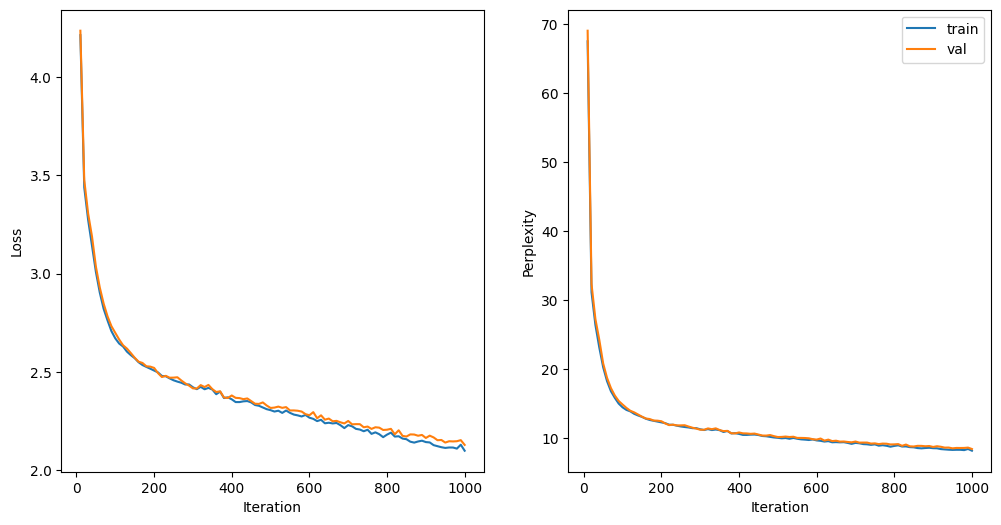

In [41]:
plot_losses_perplexity(train_losses, val_losses)


2. Run the same training loop but modify one of the hyperparameters from this list: 

In [42]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

Iter 0, Train loss: 3.902311325073242, Val loss: 3.9247424602508545
Iter 10, Train loss: 3.1927053928375244, Val loss: 3.2356903553009033
Iter 20, Train loss: 2.9786312580108643, Val loss: 3.003537654876709
Iter 30, Train loss: 2.813986301422119, Val loss: 2.8446907997131348
Iter 40, Train loss: 2.7181169986724854, Val loss: 2.7165727615356445
Iter 50, Train loss: 2.648611545562744, Val loss: 2.6506905555725098
Iter 60, Train loss: 2.606403112411499, Val loss: 2.628103017807007
Iter 70, Train loss: 2.5841381549835205, Val loss: 2.5802862644195557
Iter 80, Train loss: 2.553226947784424, Val loss: 2.571362257003784
Iter 90, Train loss: 2.5303776264190674, Val loss: 2.540318250656128
Iter 100, Train loss: 2.5217695236206055, Val loss: 2.5328540802001953
Iter 110, Train loss: 2.4986536502838135, Val loss: 2.5101866722106934
Iter 120, Train loss: 2.4935104846954346, Val loss: 2.502990484237671
Iter 130, Train loss: 2.4618330001831055, Val loss: 2.4599311351776123
Iter 140, Train loss: 2.454

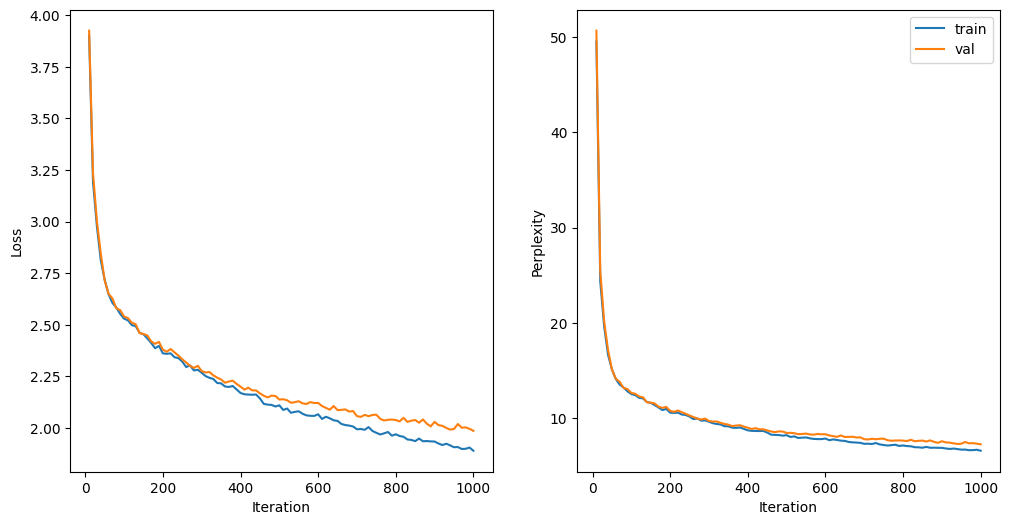

Iter 0, Train loss: 3.87884521484375, Val loss: 3.904092788696289
Iter 10, Train loss: 3.2241058349609375, Val loss: 3.265688896179199
Iter 20, Train loss: 3.0149614810943604, Val loss: 3.0762224197387695
Iter 30, Train loss: 2.838724374771118, Val loss: 2.868908166885376
Iter 40, Train loss: 2.7251687049865723, Val loss: 2.756319999694824
Iter 50, Train loss: 2.6595232486724854, Val loss: 2.6843273639678955
Iter 60, Train loss: 2.612447738647461, Val loss: 2.6282880306243896
Iter 70, Train loss: 2.584820508956909, Val loss: 2.5858917236328125
Iter 80, Train loss: 2.576017141342163, Val loss: 2.6077914237976074
Iter 90, Train loss: 2.555190324783325, Val loss: 2.5647518634796143
Iter 100, Train loss: 2.523148536682129, Val loss: 2.5259151458740234
Iter 110, Train loss: 2.493093490600586, Val loss: 2.496898889541626
Iter 120, Train loss: 2.4907796382904053, Val loss: 2.4930341243743896
Iter 130, Train loss: 2.455646514892578, Val loss: 2.4727630615234375
Iter 140, Train loss: 2.42929005

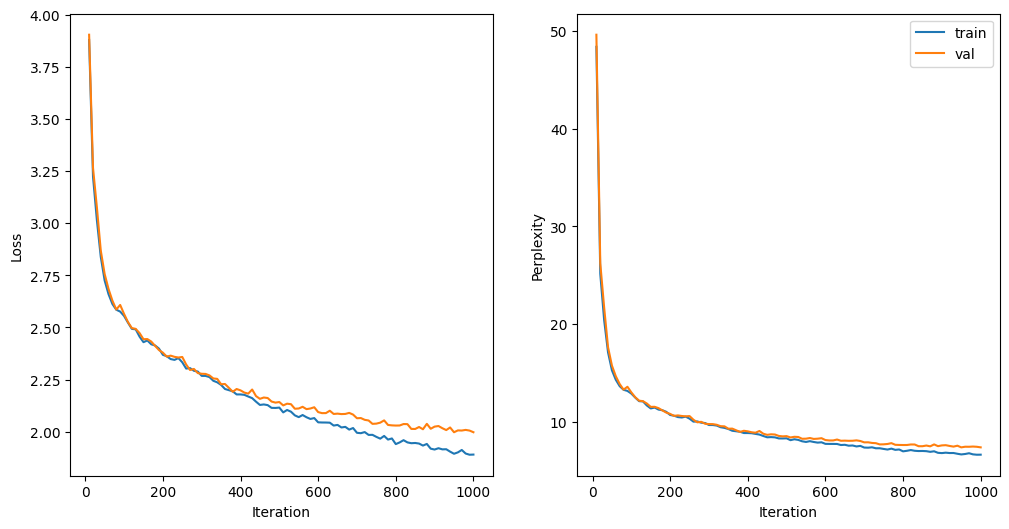

Iter 0, Train loss: 3.935793399810791, Val loss: 3.9482526779174805
Iter 10, Train loss: 3.2129580974578857, Val loss: 3.240551710128784
Iter 20, Train loss: 3.0139575004577637, Val loss: 3.03047513961792
Iter 30, Train loss: 2.849749803543091, Val loss: 2.8688929080963135
Iter 40, Train loss: 2.7267589569091797, Val loss: 2.747542381286621
Iter 50, Train loss: 2.6543335914611816, Val loss: 2.6658387184143066
Iter 60, Train loss: 2.611701250076294, Val loss: 2.6082656383514404
Iter 70, Train loss: 2.5786240100860596, Val loss: 2.5795822143554688
Iter 80, Train loss: 2.561354160308838, Val loss: 2.564065456390381
Iter 90, Train loss: 2.5417304039001465, Val loss: 2.5497734546661377
Iter 100, Train loss: 2.521636962890625, Val loss: 2.528827428817749
Iter 110, Train loss: 2.508307456970215, Val loss: 2.504643440246582
Iter 120, Train loss: 2.4880940914154053, Val loss: 2.4977328777313232
Iter 130, Train loss: 2.475815773010254, Val loss: 2.479703664779663
Iter 140, Train loss: 2.44466161

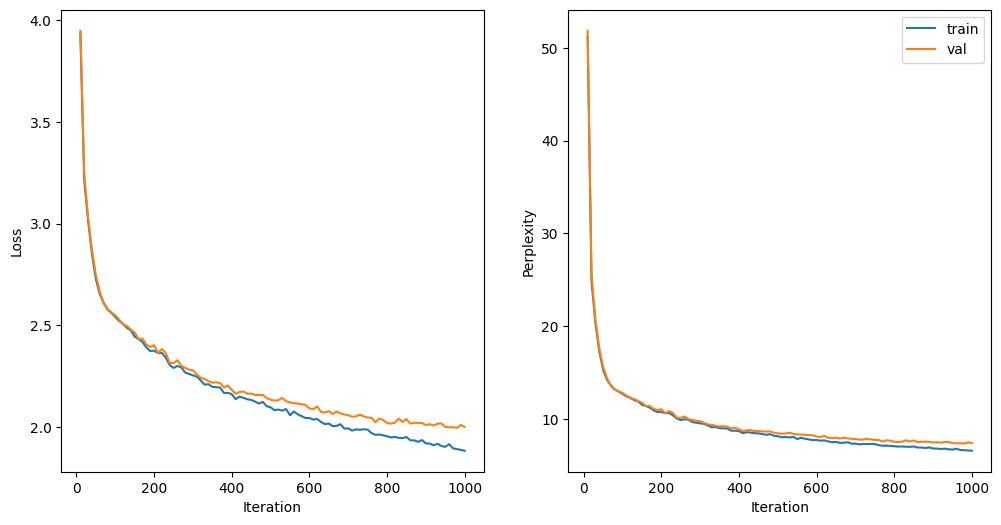

Iter 0, Train loss: 3.908339738845825, Val loss: 3.9180026054382324
Iter 10, Train loss: 3.188230037689209, Val loss: 3.234419584274292
Iter 20, Train loss: 2.966108798980713, Val loss: 3.00797700881958
Iter 30, Train loss: 2.8468966484069824, Val loss: 2.8653979301452637
Iter 40, Train loss: 2.737858295440674, Val loss: 2.7597768306732178
Iter 50, Train loss: 2.667559862136841, Val loss: 2.673245429992676
Iter 60, Train loss: 2.6258609294891357, Val loss: 2.620065927505493
Iter 70, Train loss: 2.601687431335449, Val loss: 2.5863547325134277
Iter 80, Train loss: 2.5528292655944824, Val loss: 2.5550599098205566
Iter 90, Train loss: 2.543759346008301, Val loss: 2.539942979812622
Iter 100, Train loss: 2.534360408782959, Val loss: 2.528710126876831
Iter 110, Train loss: 2.493651866912842, Val loss: 2.5042362213134766
Iter 120, Train loss: 2.4820947647094727, Val loss: 2.498108148574829
Iter 130, Train loss: 2.462556838989258, Val loss: 2.475963830947876
Iter 140, Train loss: 2.452907323837

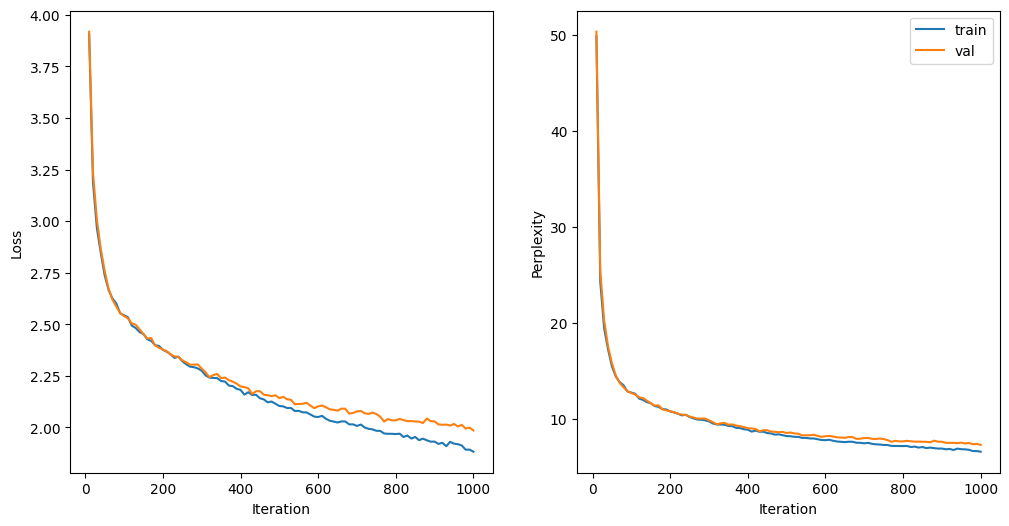

In [44]:
n_embd = 128
n_head = 4 ## so head_size = 32
n_layer = 4

# train and plot (with the new hyperparameters, run it 4 times)
for _ in range(4):
    simple_lm_nembd128 = LanguageModel().to(device)
    optimizer = torch.optim.Adam(simple_lm_nembd128.parameters(), lr=learning_rate)
    train_losses, val_losses = train_loop(simple_lm_nembd128, max_iters//5, eval_interval)
    plot_losses_perplexity(train_losses, val_losses)


Iter 0, Train loss: 4.173635959625244, Val loss: 4.172486782073975
Iter 10, Train loss: 3.4254579544067383, Val loss: 3.4564669132232666
Iter 20, Train loss: 3.264052629470825, Val loss: 3.301583766937256
Iter 30, Train loss: 3.1656076908111572, Val loss: 3.196608066558838
Iter 40, Train loss: 3.04073429107666, Val loss: 3.0749576091766357
Iter 50, Train loss: 2.9191579818725586, Val loss: 2.9474899768829346
Iter 60, Train loss: 2.8297557830810547, Val loss: 2.851529598236084
Iter 70, Train loss: 2.7655251026153564, Val loss: 2.7845325469970703
Iter 80, Train loss: 2.7073233127593994, Val loss: 2.724421977996826
Iter 90, Train loss: 2.668621778488159, Val loss: 2.683955430984497
Iter 100, Train loss: 2.644697666168213, Val loss: 2.6437501907348633
Iter 110, Train loss: 2.626774311065674, Val loss: 2.6327123641967773
Iter 120, Train loss: 2.615379571914673, Val loss: 2.6171963214874268
Iter 130, Train loss: 2.600295305252075, Val loss: 2.603975534439087
Iter 140, Train loss: 2.591375350

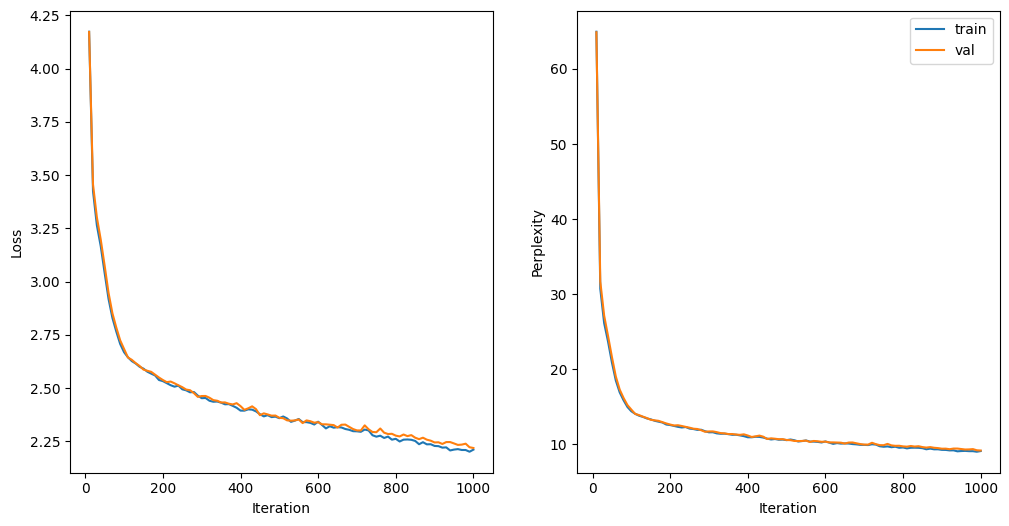

Iter 0, Train loss: 4.148031234741211, Val loss: 4.141663074493408
Iter 10, Train loss: 3.436948299407959, Val loss: 3.4673824310302734
Iter 20, Train loss: 3.2708420753479004, Val loss: 3.30570125579834
Iter 30, Train loss: 3.1720387935638428, Val loss: 3.1979825496673584
Iter 40, Train loss: 3.0121588706970215, Val loss: 3.0456604957580566
Iter 50, Train loss: 2.9155120849609375, Val loss: 2.939985990524292
Iter 60, Train loss: 2.822394609451294, Val loss: 2.8558754920959473
Iter 70, Train loss: 2.766125440597534, Val loss: 2.788609027862549
Iter 80, Train loss: 2.723803758621216, Val loss: 2.7356579303741455
Iter 90, Train loss: 2.6916069984436035, Val loss: 2.7011022567749023
Iter 100, Train loss: 2.6655335426330566, Val loss: 2.678011894226074
Iter 110, Train loss: 2.6355230808258057, Val loss: 2.6479406356811523
Iter 120, Train loss: 2.621535539627075, Val loss: 2.6361682415008545
Iter 130, Train loss: 2.600780725479126, Val loss: 2.611025333404541
Iter 140, Train loss: 2.5816419

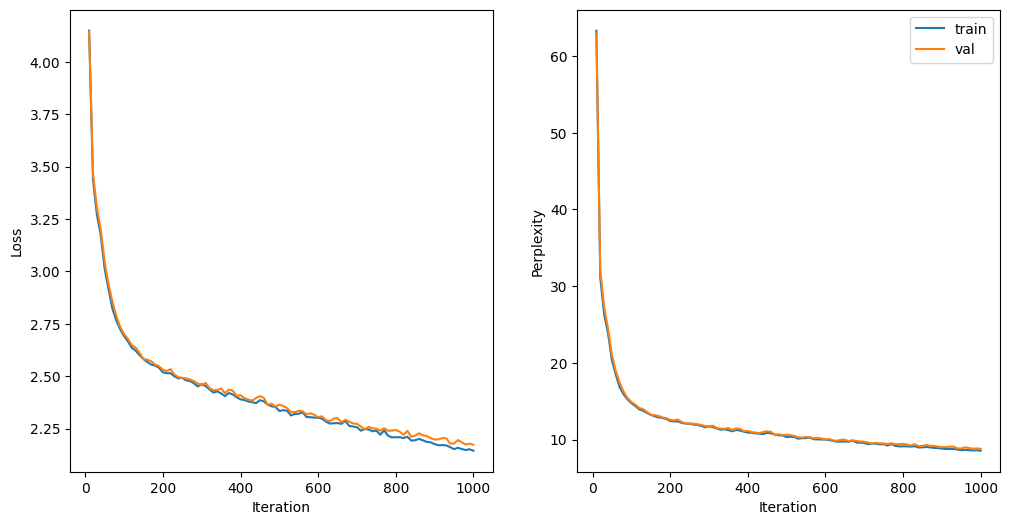

Iter 0, Train loss: 4.163311958312988, Val loss: 4.154245376586914
Iter 10, Train loss: 3.4226441383361816, Val loss: 3.4640884399414062
Iter 20, Train loss: 3.259714365005493, Val loss: 3.2939696311950684
Iter 30, Train loss: 3.1384451389312744, Val loss: 3.186587333679199
Iter 40, Train loss: 3.029890537261963, Val loss: 3.0689914226531982
Iter 50, Train loss: 2.9268221855163574, Val loss: 2.947446346282959
Iter 60, Train loss: 2.8393402099609375, Val loss: 2.858919382095337
Iter 70, Train loss: 2.78403902053833, Val loss: 2.800996780395508
Iter 80, Train loss: 2.726508378982544, Val loss: 2.7451694011688232
Iter 90, Train loss: 2.694185495376587, Val loss: 2.7021901607513428
Iter 100, Train loss: 2.6499969959259033, Val loss: 2.6634633541107178
Iter 110, Train loss: 2.636932373046875, Val loss: 2.643737554550171
Iter 120, Train loss: 2.615098237991333, Val loss: 2.6235108375549316
Iter 130, Train loss: 2.6005921363830566, Val loss: 2.6086361408233643
Iter 140, Train loss: 2.58230996

In [ ]:
n_embd = 64
n_head = 16 ## so head_size = 4
n_layer = 4

# train and plot (with the new hyperparameters, run it 4 times)
for _ in range(4):
    simple_lm_nhead16 = LanguageModel().to(device)
    optimizer = torch.optim.Adam(simple_lm_nhead16.parameters(), lr=learning_rate)
    train_losses, val_losses = train_loop(simple_lm_nhead16, max_iters//5, eval_interval)
    plot_losses_perplexity(train_losses, val_losses)


Iter 0, Train loss: 4.2915239334106445, Val loss: 4.294921398162842
Iter 10, Train loss: 3.5356497764587402, Val loss: 3.5585384368896484
Iter 20, Train loss: 3.285398006439209, Val loss: 3.3126635551452637
Iter 30, Train loss: 3.1940417289733887, Val loss: 3.219475030899048
Iter 40, Train loss: 3.085096836090088, Val loss: 3.115490198135376
Iter 50, Train loss: 2.9820051193237305, Val loss: 3.0013973712921143
Iter 60, Train loss: 2.9032142162323, Val loss: 2.921849250793457
Iter 70, Train loss: 2.829409122467041, Val loss: 2.8406739234924316
Iter 80, Train loss: 2.7644259929656982, Val loss: 2.7849903106689453
Iter 90, Train loss: 2.7194275856018066, Val loss: 2.7483670711517334
Iter 100, Train loss: 2.6978321075439453, Val loss: 2.7157680988311768
Iter 110, Train loss: 2.662616491317749, Val loss: 2.677264928817749
Iter 120, Train loss: 2.6495940685272217, Val loss: 2.649151086807251
Iter 130, Train loss: 2.627932071685791, Val loss: 2.6253063678741455
Iter 140, Train loss: 2.6060950

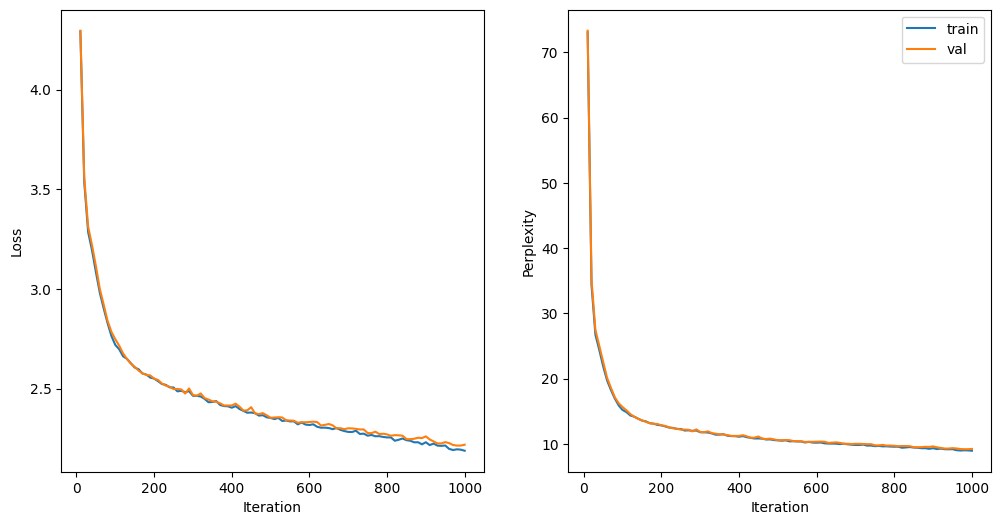

Iter 0, Train loss: 4.2236552238464355, Val loss: 4.227942943572998
Iter 10, Train loss: 3.51466703414917, Val loss: 3.542393684387207
Iter 20, Train loss: 3.284295082092285, Val loss: 3.3171753883361816
Iter 30, Train loss: 3.2204983234405518, Val loss: 3.2574667930603027
Iter 40, Train loss: 3.148036479949951, Val loss: 3.176927089691162
Iter 50, Train loss: 3.0469446182250977, Val loss: 3.068596839904785
Iter 60, Train loss: 2.9653091430664062, Val loss: 2.989034414291382
Iter 70, Train loss: 2.888545274734497, Val loss: 2.907472610473633
Iter 80, Train loss: 2.812553644180298, Val loss: 2.840258836746216
Iter 90, Train loss: 2.754960060119629, Val loss: 2.7708818912506104
Iter 100, Train loss: 2.7186343669891357, Val loss: 2.7270455360412598
Iter 110, Train loss: 2.6868131160736084, Val loss: 2.697408437728882
Iter 120, Train loss: 2.6635124683380127, Val loss: 2.6585700511932373
Iter 130, Train loss: 2.640130043029785, Val loss: 2.6450469493865967
Iter 140, Train loss: 2.622338533

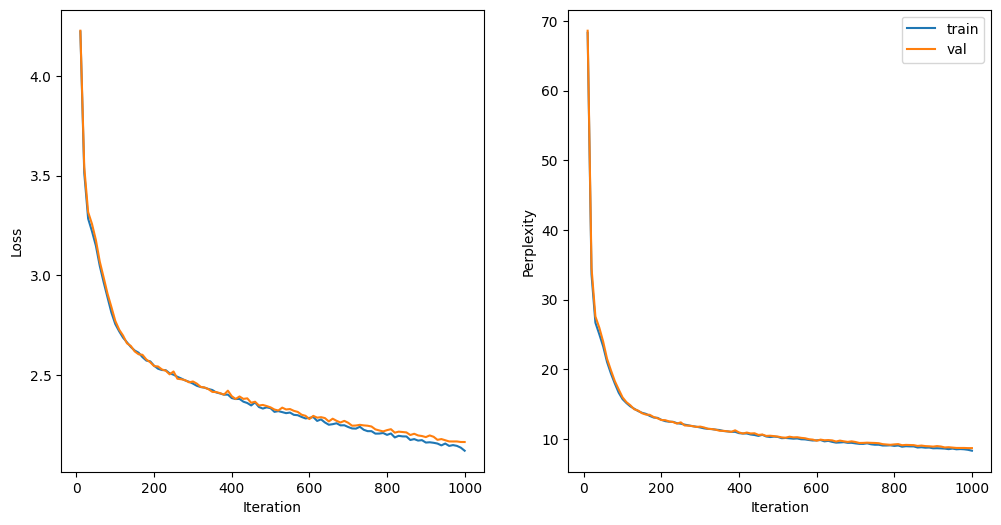

Iter 0, Train loss: 4.192348003387451, Val loss: 4.200864315032959
Iter 10, Train loss: 3.544318199157715, Val loss: 3.5792315006256104
Iter 20, Train loss: 3.300846815109253, Val loss: 3.325796604156494
Iter 30, Train loss: 3.194307804107666, Val loss: 3.2200984954833984
Iter 40, Train loss: 3.0902178287506104, Val loss: 3.112213134765625
Iter 50, Train loss: 2.988165855407715, Val loss: 3.020585298538208
Iter 60, Train loss: 2.9058053493499756, Val loss: 2.936319589614868
Iter 70, Train loss: 2.8553009033203125, Val loss: 2.864408493041992
Iter 80, Train loss: 2.780311346054077, Val loss: 2.8128662109375
Iter 90, Train loss: 2.753183603286743, Val loss: 2.777153968811035
Iter 100, Train loss: 2.7114484310150146, Val loss: 2.7330329418182373
Iter 110, Train loss: 2.680572271347046, Val loss: 2.6928343772888184
Iter 120, Train loss: 2.649868965148926, Val loss: 2.666214942932129
Iter 130, Train loss: 2.6338610649108887, Val loss: 2.644345998764038
Iter 140, Train loss: 2.60678172111511

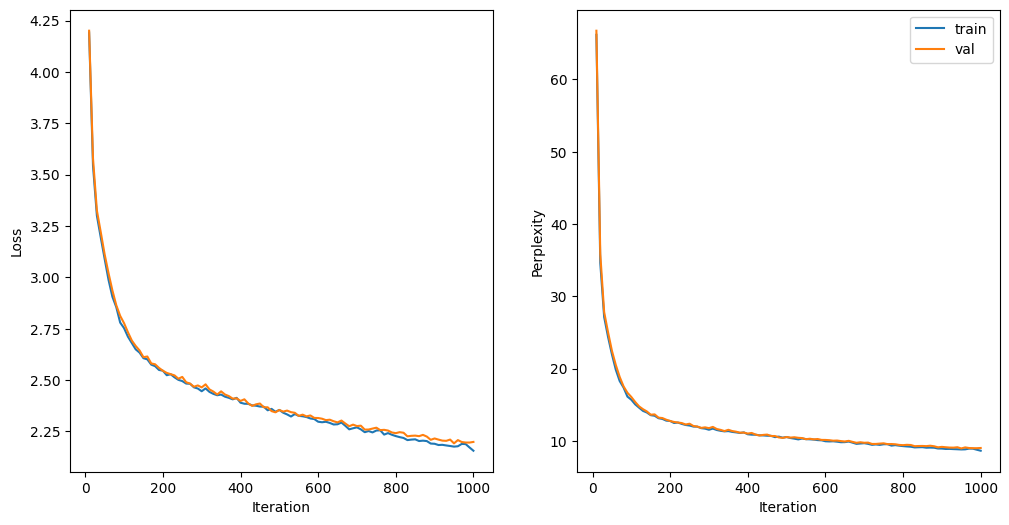

Iter 0, Train loss: 4.213070869445801, Val loss: 4.21600341796875
Iter 10, Train loss: 3.546687126159668, Val loss: 3.581622838973999
Iter 20, Train loss: 3.2892234325408936, Val loss: 3.326364040374756
Iter 30, Train loss: 3.1715590953826904, Val loss: 3.223850727081299
Iter 40, Train loss: 3.0674219131469727, Val loss: 3.110485315322876
Iter 50, Train loss: 2.979672431945801, Val loss: 3.0149037837982178
Iter 60, Train loss: 2.898726224899292, Val loss: 2.921224355697632
Iter 70, Train loss: 2.8305559158325195, Val loss: 2.8613991737365723
Iter 80, Train loss: 2.7738168239593506, Val loss: 2.7930192947387695
Iter 90, Train loss: 2.731081008911133, Val loss: 2.749307870864868
Iter 100, Train loss: 2.69541072845459, Val loss: 2.7070930004119873
Iter 110, Train loss: 2.6646032333374023, Val loss: 2.691033363342285
Iter 120, Train loss: 2.654127836227417, Val loss: 2.6711621284484863
Iter 130, Train loss: 2.629157781600952, Val loss: 2.6396329402923584
Iter 140, Train loss: 2.61618256568

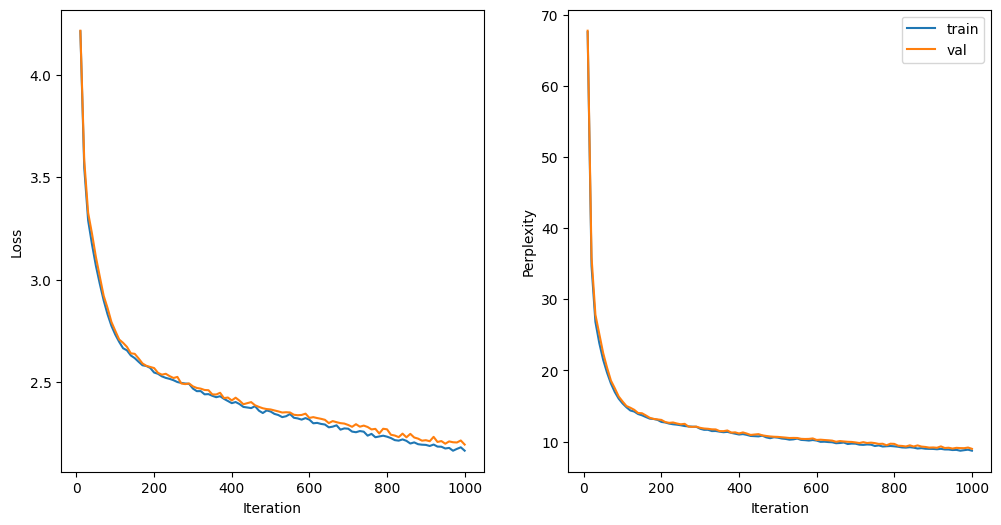

In [49]:
n_embd = 64
n_head = 4 ## so head_size = 4
n_layer = 2

# train and plot (with the new hyperparameters, run it 4 times)
for _ in range(4):
    simple_lm_nlayer2 = LanguageModel().to(device)
    optimizer = torch.optim.Adam(simple_lm_nlayer2.parameters(), lr=learning_rate)
    train_losses, val_losses = train_loop(simple_lm_nlayer2, max_iters//5, eval_interval)
    plot_losses_perplexity(train_losses, val_losses)

Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others? 

In [46]:
# generate text from the trained models
def generate_text(model, text, max_new_tokens):
    model.eval()
    with torch.no_grad():
        idx = torch.tensor(encode(text), dtype=torch.long, device=device).unsqueeze(0)
        idx = model.generate(idx, max_new_tokens)
    return decode(idx[0].cpu().numpy())

In [47]:
generate_text(simple_lm, 'This is a good day', 100)

"This is a good daypardumde\nVie, if nie lenovest carle drouce, foct\nCow'd me dy ard erdelis'llw!rese, Herd wouldwwere a"

In [48]:
generate_text(simple_lm_nembd128, 'This is a good day', 100)

'This is a good day! I and do dame;\nOr not his as men the him satcon,\nWelost to so his with st the now throw\nYave that '

In [ ]:
generate_text(simple_lm_nhead16, 'This is a good day', 100)

In [ ]:
generate_text(simple_lm_nlayer2, 'This is a good day', 100)

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different 

In [46]:
!pip install bertviz
!pip install flash_attnpip install flash_attn
!pip install flash_attn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement flash_attnpip (from ve

In [ ]:
!meta-llama/Llama-2-7b

In [51]:
!pip install -U "huggingface_hub[cli]"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for huggingface_hub[cli] from https://files.pythonhosted.org/packages/05/c0/779afbad8e75565c09ffa24a88b5dd7e293c92b74eb09df6435fc58ac986/huggingface_hub-0.22.2-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2023.5.0 from https://files.pythonhosted.org/packages/93/6d/66d48b03460768f523da62a57a7e14e5e95fdf339d79e996ce3cecda2cdb/fsspec-2024.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for InquirerPy==0.3.4 from https://files.pythonhosted.org/packages/ce/ff/3b59672c47c6284e8005b42e84ceba13864aa0f39f067c973d1af02f5d9

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tok

In [56]:
!pip install flash_attn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [60]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'model-attribution-challenge/openai-gpt'
input_text = "No, I am your father"  
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, trust_remote_code=True)


In [61]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids einops
sentencepiece
torch
transformers
to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"